In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

import pandas as pd
import numpy as np

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
feats_import = pd.read_csv('All_Data_2006_2016.csv', index_col=0)

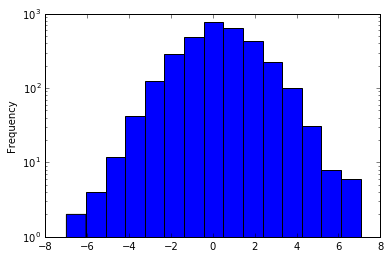

In [1002]:
fig, ax = pyplot.subplots()
feats_import.loc[:, 'FTGD'].plot(kind='hist', bins=16)
ax.set_yscale('log')

In [1003]:
# Test dropping out certain features, outdated. 

# kfold = KFold(n_splits=10, shuffle=True)

# performance_list = []
# for i in range(1,21,2):
#     if i<3:
#         continue
#     np.random.seed(7)
#     X_vary = np.delete(X,(i,i+1),1)
    
#     def baseline_model():
#         model = Sequential()
#         model.add(Dense(40, input_dim=len(X_vary[0]), init='uniform', activation='relu')) 
#         # model.add(Dropout(0.3))
#         model.add(Dense(20, activation='sigmoid'))
#         model.add(Dense(80, activation='relu'))
#         model.add(Dense(2*cutoff_GD+1, activation='sigmoid'))

#         model.compile(optimizer='adam',
#                       loss='categorical_crossentropy',
#                       metrics=['accuracy'])
#         return model
#     estimator = KerasClassifier(build_fn=baseline_model, nb_epoch=20, batch_size=20, verbose=0)
    
#     results = cross_val_score(estimator, X_vary, y, cv=kfold)
#     print feats.columns[i:i+2]
#     print [i, 100*results.mean(), 100*results.std()]
#     performance_list += [i, 100*results.mean(), 100*results.std()]


In [ ]:
# Outdated

# np.random.seed(7)
# X_vary = X

# def baseline_model():
#     model = Sequential()
#     model.add(Dense(40, input_dim=len(X_vary[0]), init='lecun_uniform', activation='relu')) 
#     model.add(Dense(20, activation='relu'))
#     model.add(Dense(2*cutoff_GD+1, activation='sigmoid'))
#     model.add(Activation('softmax'))

#     model.compile(optimizer='adam',
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])
#     return model
# estimator = KerasClassifier(build_fn=baseline_model, nb_epoch=100, batch_size=10, verbose=0)

# results = cross_val_score(estimator, X_vary, y)
# print 100*results.mean(), 100*results.std()

In [1008]:
# Goal differential Cut-off.
cutoff_GD = 2

feats = feats_import.drop(['Season', 'Gameday', 'TID_H', 'TID_A'], axis=1).drop('FTGD', axis=1)
feats.loc[:, 'HTGD'] = feats_import.loc[:, 'HTGD'].apply(min, args=(cutoff_GD,)).apply(max, args=(-cutoff_GD,)) + cutoff_GD

label = feats_import.loc[:, 'FTGD'].apply(min, args=(cutoff_GD,)).apply(max, args=(-cutoff_GD,)) + cutoff_GD

GD_min = -cutoff_GD
GD_max = +cutoff_GD
GD_spread = GD_max-GD_min + 1


# Different norms because I played around with different columns
norm = [9, 5, 36, 36, 36, 33, 35, 35, 20, 20, 11, 11, 4, 4, 1, 1, GD_spread-1, 1, 1, 1]
#norm = [9, 5, 36, 36, 36, 33, 35, 35, 20, 20, 1, 1, GD_spread-1, 1, 1, 1]
#norm = [9, 5, 36, 36, 36, 33, 35, 35, 20, 20, 11, 11, 4, 4, GD_spread-1, 1, 1, 1]

feats = feats/norm


ID = np.eye(GD_spread)

X = feats.iloc[:3000].as_matrix()
y_pre = map(int, label.iloc[:3000].as_matrix())

y = np.array([ID[i] for i in y_pre])

feats.head()

,FTHG,HTHG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,HGA,AGA,HTGD,Odds,HP3,AP3
0,0.000000,0.0,0.277778,0.305556,0.222222,0.242424,0.342857,0.685714,0.25,0.30,0.090909,0.181818,0.00,0.00,0.309091,0.727273,0.00,0.656250,0.5,0.5
1,0.333333,0.4,0.555556,0.222222,0.305556,0.151515,0.628571,0.228571,0.25,0.05,0.272727,0.000000,0.25,0.25,0.654545,0.300000,1.00,0.819444,0.5,0.5
2,0.222222,0.0,0.361111,0.305556,0.222222,0.212121,0.314286,0.685714,0.15,0.25,0.000000,0.363636,0.00,0.25,0.545455,0.427273,0.50,0.760007,0.5,0.5
3,0.222222,0.2,0.333333,0.444444,0.250000,0.212121,0.400000,0.571429,0.20,0.20,0.090909,0.181818,0.00,0.00,0.654545,0.381818,0.75,0.775832,0.5,0.5
4,0.111111,0.2,0.666667,0.222222,0.361111,0.151515,0.485714,0.542857,0.35,0.25,0.090909,0.181818,0.00,0.00,0.581818,0.363636,0.75,0.819444,0.5,0.5


In [1009]:
# Assign an expected score with probabilities
def exp_score(x):
    multiplier = np.array(range(-cutoff_GD, cutoff_GD+1))
    return np.sum(np.array(x) * multiplier)

In [1022]:
# Run Keras
np.random.seed(7)

# I tested these parameters a little bit; they seem to work nicely for know.
model = Sequential()
model.add(Dense(10, input_dim=len(X[0]), init='lecun_uniform', activation='relu')) 
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*cutoff_GD+1, activation='relu'))
model.add(Activation('softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X, y, nb_epoch=100, batch_size=10, verbose=False)
print model.evaluate(X, y, batch_size=10, verbose=False)[1]

predictions = model.predict_proba(X)

0.720333334506
2368/3000 [======================>.......] - ETA: 0s

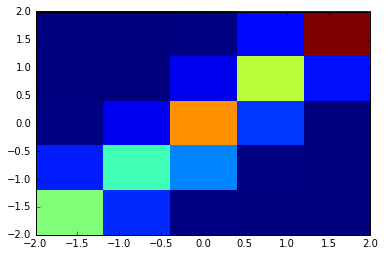

In [1019]:
# Matrix Plot to visualize predictions vs. outcome

# x-axis: Actual outcome
# y-axis: Expected score (EXP)
plt_x = np.array(performance_df.loc[:, "FTGD"])
plt_y = np.array(performance_df.loc[:, "EXP"])

fig, ax = plt.subplots()

plt.hist2d(plt_x, plt_y, bins=2*cutoff_GD+1, range=np.array([(-cutoff_GD,cutoff_GD), (-cutoff_GD,cutoff_GD)]))
plt.show()

In [1020]:
# Cross-Tabulation for Away-Win (-1), Draw (0) or Home-win (1)
performance_df = pd.concat([
        feats_import.iloc[:3000,-5].apply(min, args=(cutoff_GD,)).apply(max, args=(-cutoff_GD,)),
        pd.Series(data=map(np.round, map(exp_score, predictions)), name='EXP', index=feats_import.iloc[:3000].index)], axis=1)
success_res_df = pd.crosstab(performance_df.loc[:, "FTGD"].apply(np.sign), performance_df.loc[:, "EXP"].apply(np.sign))
print "Success identifying H, D, A is " + str(round(100* np.trace(success_res_df)/3000.,2)) + " percent"
success_res_df


Success identifying H, D, A is 85.9 percent


EXP,-1.0,0.0,1.0
FTGD,,,
-1.0,812,86,4
0.0,141,500,101
1.0,3,88,1265


In [1021]:
# Cross-Tabulation for exact goal differential

success_df = pd.crosstab(performance_df.loc[:, "FTGD"], performance_df.loc[:, "EXP"])#, margins=True)
exp_min = int(performance_df.loc[:, "EXP"].min())
exp_max = int(performance_df.loc[:, "EXP"].max())
print "Success identifying GD is " + str(round(np.sum([100*success_df.ix[i,i] for i in range(exp_min,exp_max+1)])/3000.,2)) + " percent"
success_df

Success identifying GD is 69.3 percent


EXP,-2.0,-1.0,-0.0,1.0,2.0
FTGD,,,,,
-2.0,148,292,3,0,0
-1.0,7,365,83,4,0
0.0,0,141,500,97,4
1.0,0,3,88,382,124
2.0,0,0,0,75,684


In [1007]:
# Check one example.
i=1123
print [round(predictions[i][j], 2) for j in range(len(predictions[i]))]
print exp_score(predictions[i])
print label[i]

[0.0, 0.0, 0.03, 0.9, 0.07, 0.0, 0.0]
0.03484211881
3.0
